In [ ]:
!nvidia-smi

Wed Feb 24 01:37:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd /content

/content


In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2021-02-24 21:54:38--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  19.6MB/s    in 19s     

2021-02-24 21:54:57 (12.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
!unzip -q tiny-imagenet-200.zip

In [ ]:
!git clone https://github.com/ShivamShrirao/tiny-imagenet-test

Cloning into 'tiny-imagenet-test'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 17 (delta 4), reused 14 (delta 1), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [ ]:
%cd tiny-imagenet-test

/content/tiny-imagenet-test


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import glob
import os
import csv
from tqdm.notebook import tqdm
from time import time
import random
%matplotlib inline

In [ ]:
# tf.keras.backend.set_image_data_format('channels_first')

In [ ]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

In [ ]:
import preprocessing

In [ ]:
preprocessing.img_height, preprocessing.img_width = 64, 64
preprocessing.BATCH_SIZE = 128

In [ ]:
# MOVE DATA LOADING TO FILES

In [ ]:
TRAIN_PATH = "../tiny-imagenet-200/train/"
TEST_PATH = "../tiny-imagenet-200/test/"
VAL_PATH = "../tiny-imagenet-200/val/"

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
class_names = np.array(sorted([fp.split('/')[-1] for fp in glob.glob(TRAIN_PATH+"*")]))

In [ ]:
val_labels = {}
with open(VAL_PATH+"val_annotations.txt") as fIn:
    reader = csv.reader(fIn, delimiter='\t')
    for row in reader:
        val_labels[row[0]] = row[1]

In [ ]:
train_list_ds = (
    tf.data.Dataset.list_files(TRAIN_PATH+"*/images/*", shuffle=True)
    .map(preprocessing.process_train_path, num_parallel_calls=AUTOTUNE)
    .cache()
)

In [ ]:
val_list_ds = (
    tf.data.Dataset.list_files(VAL_PATH+"images/*")
    .map(preprocessing.process_val_path, num_parallel_calls=AUTOTUNE)
    .cache()
)

In [ ]:
mean = []
std = []
for a,b in train_list_ds.take(1024):
    mean.append(a.numpy())
    std.append(a.numpy())
mean = np.asarray(mean).mean(axis=(0,1,2)).reshape(1,3,1,1)
std = np.asarray(std).std(axis=(0,1,2)).reshape(1,3,1,1)

In [ ]:
mean.ravel(), std.ravel()

(array([0.47657734, 0.45386508, 0.3950202 ], dtype=float32),
 array([0.27600715, 0.26707038, 0.2805239 ], dtype=float32))

In [ ]:
mean = tf.convert_to_tensor(mean)
std = tf.convert_to_tensor(std)

In [ ]:
train_ds = (
    train_list_ds
    .map(preprocessing.augment_wrapper, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (preprocessing.data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: preprocessing.channel_first_and_normalize(x, y, mean, std), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_list_ds
    .batch(BATCH_SIZE)
    .map(lambda x, y: preprocessing.channel_first_and_normalize(x, y, mean, std), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [ ]:
a, b = next(iter(train_ds))
a.shape

TensorShape([128, 3, 64, 64])

In [ ]:
idx = np.random.randint(0,128)
x = a.numpy()[idx]
z = (x-x.min())/(x.max()-x.min())
z = z.transpose(1,2,0)
class_names[b[idx]]

'n03649909'

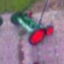

In [ ]:
PIL.Image.fromarray((z*255).astype(np.uint8))

In [ ]:
config_defaults = {
    'activation'            : 'leaky_relu',
    'dp_rate'               : 0.2,
    'batch_size'            : BATCH_SIZE,
    'norm'                  : 'bn',
    'self_attn'             : True,
    'frac_dk'               : 0.5,
    'frac_dv'               : 0.25,
    'pos_emb'               : True,
    'optimizer'             : 'adamw',
    'min_lr'                : 1e-5,
    'max_lr'                : 1e-3,
    'weight_decay'          : 1e-4,     #maximum
    'clr_step_size'         : 8,
    'loss_function'         : 'cce',
}

In [ ]:
class AttributeDict(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [ ]:
CONFIG = AttributeDict(config_defaults)

In [ ]:
import conv_utils

In [ ]:
conv_utils.CONFIG = CONFIG

In [ ]:
inp = layers.Input(shape=(3,img_height, img_width))

In [ ]:
x = conv_utils.conv_norm(inp, 8, kernel_size=5, strides=1, activation=CONFIG.activation)
x = conv_utils.conv_norm(x, 32, kernel_size=3, strides=2, activation=CONFIG.activation,
                    do_norm_act=False)

In [ ]:
x = conv_utils.down_stack(x, fltrs=[ 8,16,16], self_attn=False, dp_rate=CONFIG.dp_rate)   # (64, 16, 16)
x = conv_utils.down_stack(x, fltrs=[16,32,32], self_attn=[False, True, True], dp_rate=CONFIG.dp_rate)   # (128, 8, 8)
x = conv_utils.down_stack(x, fltrs=[32,64,64], self_attn=True, dp_rate=CONFIG.dp_rate)   # (256, 4, 4)

In [ ]:
x = conv_utils.conv_norm(x, 512, kernel_size=3, strides=1, activation=CONFIG.activation)
x = layers.GlobalAveragePooling2D(data_format="channels_first")(x)
if CONFIG.dp_rate:
    x = layers.Dropout(CONFIG.dp_rate)(x)
x = layers.Dense(CLASSES)(x)
x = layers.Softmax(axis=1)(x)

In [ ]:
model = tf.keras.Model(inputs=inp, outputs=x)
model.summary()

In [ ]:
ret = tf.keras.utils.plot_model(model, to_file='model.svg', show_shapes=True, dpi=None)

In [ ]:
steps_per_epoch = int(np.ceil(len(train_paths)/BATCH_SIZE))
clr = tfa.optimizers.Triangular2CyclicalLearningRate(
            initial_learning_rate=CONFIG.min_lr,
            maximal_learning_rate=CONFIG.max_lr,
            step_size=CONFIG.clr_step_size * steps_per_epoch,
            scale_mode="cycle")
domain = range(0, 100*steps_per_epoch, 32)
lr_log = [clr(i).numpy() for i in domain]
plt.plot(domain, lr_log)
plt.show()

In [ ]:
def get_wdc(i):
    wdc = CONFIG.weight_decay*clr(i)/CONFIG.max_lr
    if tf.executing_eagerly():
        return wdc.numpy()
    else:
        return wdc

In [ ]:
if CONFIG.optimizer == 'adamw':
    opt = tfa.optimizers.AdamW(learning_rate=clr, weight_decay=lambda : CONFIG.weight_decay)
    # wd_schedule = tf.optimizers.schedules.ExponentialDecay(5e-5, 100, 0.9)    # weight_decay=lambda : None
    if CONFIG.vary_weight_decay:
        opt.weight_decay = lambda : get_wdc(opt.iterations)
elif CONFIG.optimizer == 'adam':            # or just make weight_decay=0
    opt = tf.keras.optimizers.Adam(learning_rate=clr)
opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

In [ ]:
if CONFIG.loss_function == 'cce':
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
model.compile(optimizer=opt, loss=loss_function, metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    workers=4,
                    use_multiprocessing=True,
                    callbacks=[wandb_cb])

In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
# wandb.login()

In [ ]:
# run = wandb.init(project="tiny-imagenet-test", entity="shivamshrirao", config=config_defaults)
# CONFIG = wandb.config